## Importamos las librerias

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
from ultralytics import YOLO
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot
import yaml
import wandb

# Cargamos el dataset y preprocesamos los datos

In [3]:
class_names = [
    'prohibitory',
    'danger',
    'mandatory',
    'other'
]

data_path = os.path.abspath('yolo_dataset_signal_types/ts/ts')
images_files = [ file_name for file_name in os.listdir( data_path ) if file_name.endswith('.jpg') ]
print( len( images_files ) )

741


## Separamos las imagenes para tener el conjunto de entrenamiento y validación

In [5]:
train_images, val_images = train_test_split( images_files, test_size = 0.2, random_state = 42 )

# Directorio de salida
output_dir = 'C:/Users/PC/Desktop/Uni/TT/Object Detection/datasets/'

train_image_list = os.path.join(output_dir, 'train_images.txt')
val_image_list = os.path.join(output_dir, 'val_images.txt')

with open(train_image_list, 'w') as f:
    for item in train_images:
        f.write("%s\n" % os.path.join(data_path, item))

with open(val_image_list, 'w') as f:
    for item in val_images:
        f.write("%s\n" % os.path.join(data_path, item))

data = {
    'train': train_image_list,
    'val': val_image_list,
    'number_classes': len(class_names),
    'names': {i: name for i, name in enumerate(class_names)}
}

yaml_file = 'dataset.yaml'
with open(yaml_file, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

## Visualizamos los datos contenidos en el dataset

In [6]:
def generate_random_colors(num_classes):
    colors = []
    for _ in range(num_classes):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        colors.append(color)
    return colors

In [8]:
def plot_images_with_bboxes(image_paths, data_dir, class_names, colors):
    fig, axes = plt.subplots(4, 2, figsize=(22, 27))
    axes = axes.flatten()
    
    for idx, img_file in enumerate(image_paths):
        img_path = os.path.join(data_dir, img_file)
        label_path = os.path.join(data_dir, img_file.replace('.jpg', '.txt'))
        
        # Leer la imagen
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Leer los labels file y plotear bounding boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convertir coordenadas normalizadas a coordenadas de imagen
                    img_height, img_width, _ = image.shape
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height
                    
                    # Calcular las coordenadas de los bounding boxes
                    x_min = int(x_center - width / 2)
                    y_min = int(y_center - height / 2)
                    x_max = int(x_center + width / 2)
                    y_max = int(y_center + height / 2)
                    
                    # Dibujar los bounding boxes
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), colors[class_id], 2)
                    
                    # Agregar el label de la clase
                    label = class_names[class_id]
                    label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 6,4)
                    label_ymin = max(y_min, label_size[1] + 10)
                    cv2.putText(image, label, (x_min, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_id], 2)

        # Plotear la imagen
        axes[idx].imshow(image)
        axes[idx].axis('off')

    plt.show()

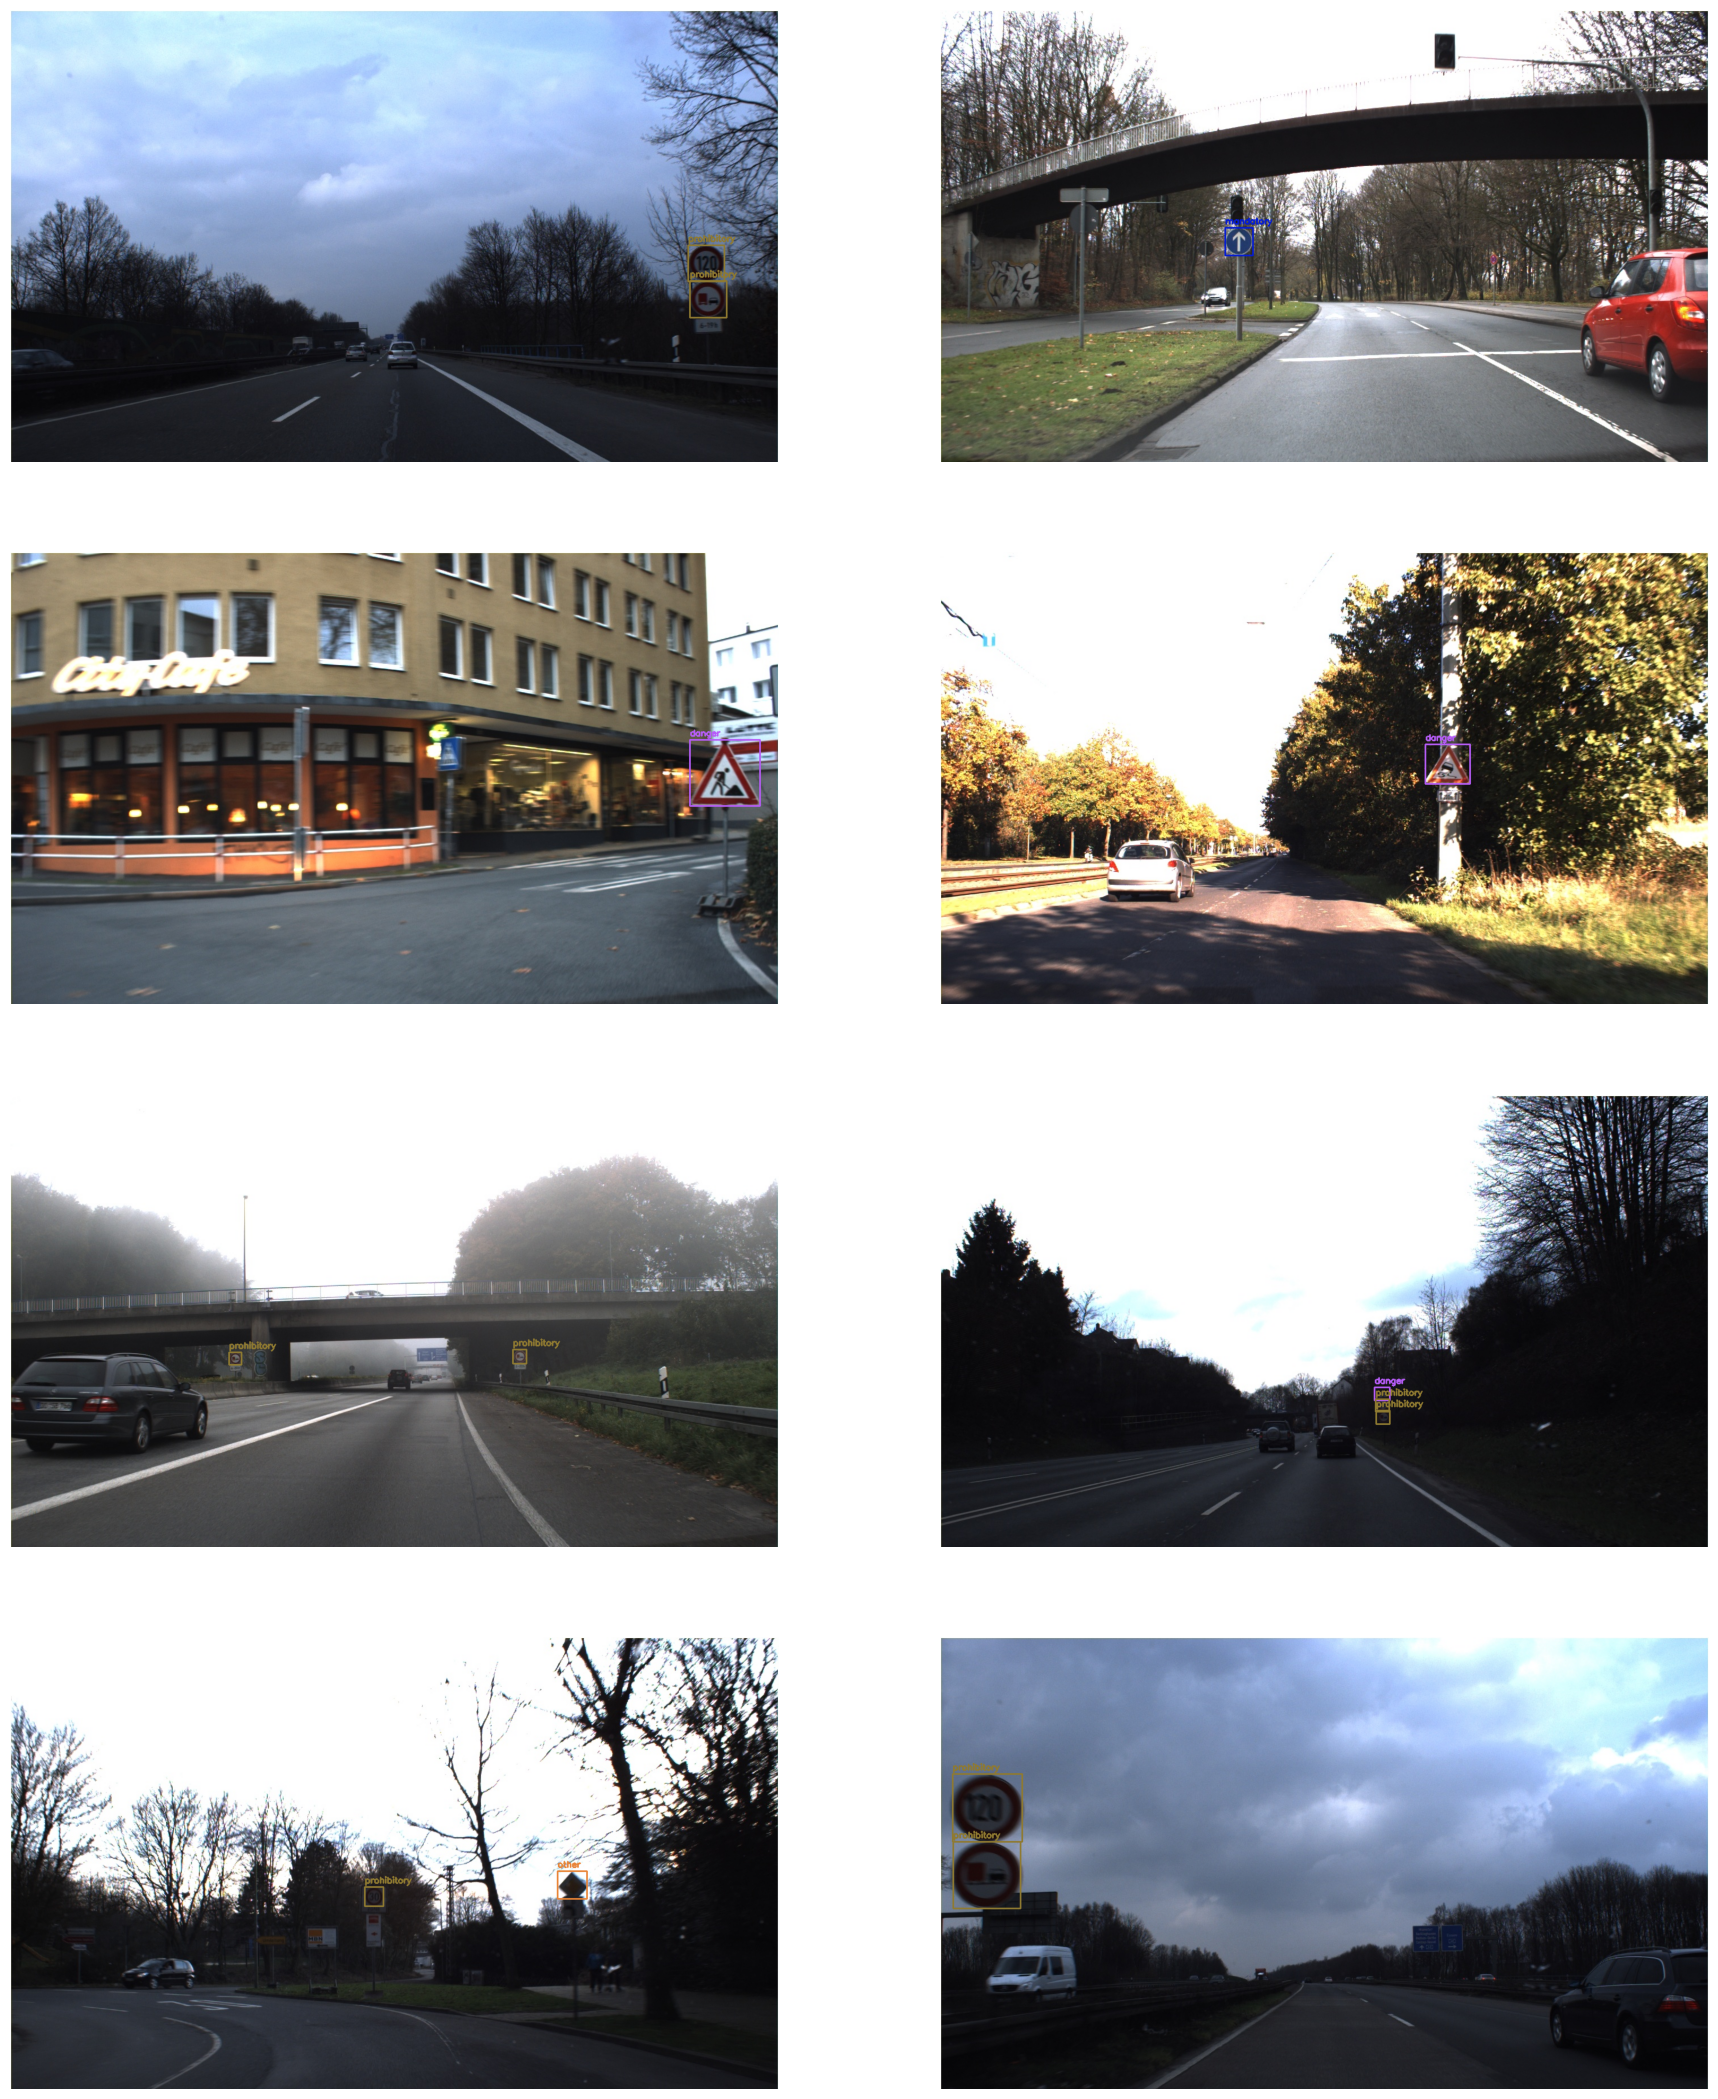

In [9]:
sampled_images = random.sample(images_files, 8)

# Generamos colores aleatorios para cada clase
colors = generate_random_colors(len(class_names))

plot_images_with_bboxes(sampled_images, data_path, class_names, colors)

## Verificamos el numero de instancias para cada clase

In [10]:
class_instance_counts = { class_id: 0 for class_id in range( len( class_names ) ) }

## Obtenemos la lista del label files
label_files = [f for f in os.listdir(data_path) if f.endswith('.txt')]

## Contamos el numero de instancia por cada clase
for label_file in label_files:

    label_path = os.path.join(data_path, label_file)
    with open(label_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            class_instance_counts[class_id] += 1

## Extraemos los nombres y la cantidad de cada clase y la ploteamos

class_ids = list(class_instance_counts.keys())
instance_counts = pd.Series((class_instance_counts.values()),name="counts")
class_labels = pd.Series([class_names[class_id] for class_id in class_ids],name="class")

df = pd.concat([class_labels,instance_counts],axis=1)

iplot(px.bar(data_frame = df,x ="class",y="counts",color_discrete_sequence=px.colors.sequential.algae\
             ,title="Number of instances of each class",template="plotly_dark"))


In [11]:
wandb.login(key="bfc39c0b4b62d3893176e8c62433782275646cb9")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mhernandezl1605 (mhernandezl1605-instituto-polit-cnico-nacional). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PC\_netrc


True

## Cargamos el modelo

In [12]:
model = YOLO("yolov8n.pt")

 ## Configuramos el modelo

In [13]:
results = model.train(
    data="dataset.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
)

Ultralytics YOLOv8.2.95  Python-3.11.3 torch-2.3.1+cpu CPU (AMD Ryzen 5 5600G with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 3.12MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Freezing layer 'model.22.dfl.conv.weight'


train: Scanning c:\Users\PC\Desktop\Uni\TT\Object Detection\yolo_dataset_signal_types\ts\ts... 592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<00:00, 759.45it/s]


train: New cache created: c:\Users\PC\Desktop\Uni\TT\Object Detection\yolo_dataset_signal_types\ts\ts.cache


val: Scanning c:\Users\PC\Desktop\Uni\TT\Object Detection\yolo_dataset_signal_types\ts\ts... 149 images, 0 backgrounds, 0 corrupt: 100%|██████████| 149/149 [00:00<00:00, 832.49it/s]

val: WARNING  c:\Users\PC\Desktop\Uni\TT\Object Detection\yolo_dataset_signal_types\ts\ts\00340.jpg: 1 duplicate labels removed


val: New cache created: c:\Users\PC\Desktop\Uni\TT\Object Detection\yolo_dataset_signal_types\ts\ts.cache
Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.395      4.399     0.9226         43        640: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]

                   all        149        240   0.000869      0.137    0.00601    0.00473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.182      2.588     0.8688         39        640: 100%|██████████| 37/37 [02:30<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        149        240      0.572     0.0563      0.472      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.107      2.027     0.8774         31        640: 100%|██████████| 37/37 [02:26<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

                   all        149        240       0.96      0.472      0.719      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.082      1.701     0.8826         39        640: 100%|██████████| 37/37 [02:27<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]

                   all        149        240       0.92      0.721       0.83      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.046      1.463     0.8562         37        640: 100%|██████████| 37/37 [02:26<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

                   all        149        240      0.919      0.718       0.84      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.005      1.332     0.8544         40        640: 100%|██████████| 37/37 [02:22<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]

                   all        149        240      0.898      0.728      0.849      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.003      1.171     0.8506         34        640: 100%|██████████| 37/37 [02:26<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

                   all        149        240      0.934      0.752      0.873       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.9535      1.089     0.8536         53        640: 100%|██████████| 37/37 [02:21<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]

                   all        149        240      0.889      0.788      0.861      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.9291      0.993     0.8472         61        640: 100%|██████████| 37/37 [02:48<00:00,  4.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]

                   all        149        240      0.919      0.802      0.886      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.9399     0.9485     0.8398         60        640: 100%|██████████| 37/37 [02:34<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]

                   all        149        240      0.919       0.83      0.912       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.8734      0.863     0.8382         30        640: 100%|██████████| 37/37 [02:37<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]

                   all        149        240      0.922      0.807        0.9      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.9242     0.8446     0.8399         46        640: 100%|██████████| 37/37 [02:36<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]

                   all        149        240      0.907      0.822      0.915      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      0.899     0.7916     0.8342         42        640: 100%|██████████| 37/37 [02:35<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

                   all        149        240      0.946      0.794      0.913       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.8666      0.737     0.8304         38        640: 100%|██████████| 37/37 [02:25<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.919       0.86      0.927      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.8845     0.7296     0.8326         37        640: 100%|██████████| 37/37 [02:24<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

                   all        149        240      0.913      0.838      0.915      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.8229     0.6923     0.8232         43        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.953      0.822      0.938      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.8165     0.6645     0.8218         49        640: 100%|██████████| 37/37 [02:24<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

                   all        149        240      0.944      0.847      0.937      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.8273       0.65     0.8231         44        640: 100%|██████████| 37/37 [02:25<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

                   all        149        240      0.935      0.865      0.938      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.8003     0.6139      0.826         50        640: 100%|██████████| 37/37 [02:25<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.889      0.855      0.935      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.8048     0.6204     0.8199         55        640: 100%|██████████| 37/37 [02:24<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.896      0.888      0.934      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.7746      0.606     0.8145         46        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.928      0.867      0.948      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.7875     0.5979     0.8224         27        640: 100%|██████████| 37/37 [02:25<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.916       0.86      0.934       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.8187     0.6021     0.8186         40        640: 100%|██████████| 37/37 [02:26<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]

                   all        149        240      0.914      0.875      0.939       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G     0.8038      0.574     0.8177         58        640: 100%|██████████| 37/37 [02:35<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.904      0.868       0.93      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      0.791     0.5555     0.8162         42        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.873      0.892      0.934      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      0.794     0.5676     0.8087         53        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        149        240      0.916      0.875      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.8002     0.5618     0.8201         45        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.942      0.854      0.942      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.7639     0.5406      0.818         48        640: 100%|██████████| 37/37 [02:25<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        149        240      0.932      0.888      0.947      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      0.745     0.5225      0.807         35        640: 100%|██████████| 37/37 [02:27<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]

                   all        149        240      0.915      0.873      0.936      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.7386      0.524     0.8146         57        640: 100%|██████████| 37/37 [02:26<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.957      0.874      0.951      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G     0.7328     0.5225     0.8126         39        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.957      0.842      0.933      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.7594      0.524     0.8157         48        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

                   all        149        240      0.946      0.893      0.952      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.7383     0.5154     0.8157         42        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.971      0.903      0.963       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.7314     0.4968     0.8083         40        640: 100%|██████████| 37/37 [02:24<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.904        0.9      0.943      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.7291     0.4914     0.8102         43        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.951      0.883      0.948      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.7485      0.511      0.807         40        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.884      0.896      0.935      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.7184     0.4844     0.8024         47        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240       0.93      0.919      0.951      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.6903     0.4677     0.8139         59        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.931      0.932      0.952      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.7241     0.4912     0.8067         46        640: 100%|██████████| 37/37 [02:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.916      0.907      0.947      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.7015     0.4639     0.8081         43        640: 100%|██████████| 37/37 [02:23<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.894      0.934      0.957      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.6975     0.4585     0.8113         43        640: 100%|██████████| 37/37 [02:28<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]

                   all        149        240      0.926      0.906      0.954      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.6904     0.4564     0.8015         53        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.929      0.921      0.957      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.6846     0.4559      0.801         43        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.939      0.924      0.947      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.7187      0.463     0.8075         66        640: 100%|██████████| 37/37 [02:25<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.919      0.916      0.956      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.7146     0.4616     0.8019         39        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.914      0.916      0.951      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.6758      0.443      0.801         53        640: 100%|██████████| 37/37 [02:24<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]

                   all        149        240       0.93      0.923      0.956      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.6699     0.4457     0.8025         40        640: 100%|██████████| 37/37 [02:28<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]

                   all        149        240      0.944      0.922      0.963      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.6746     0.4396     0.8026         45        640: 100%|██████████| 37/37 [02:23<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240       0.91       0.93      0.952      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.6514      0.412     0.8004         55        640: 100%|██████████| 37/37 [02:23<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.939      0.896      0.945      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.6808     0.4321     0.8031         53        640: 100%|██████████| 37/37 [02:23<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.938       0.91      0.955      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.6641     0.4234     0.7984         37        640: 100%|██████████| 37/37 [02:23<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.955      0.889      0.948      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.6767      0.437     0.7974         51        640: 100%|██████████| 37/37 [02:24<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]

                   all        149        240      0.947      0.889      0.951      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.6794     0.4407     0.8009         43        640: 100%|██████████| 37/37 [02:27<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.921      0.905      0.945      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.6526     0.4174     0.8076         46        640: 100%|██████████| 37/37 [02:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.934      0.918      0.964       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.6335     0.4066     0.8042         41        640: 100%|██████████| 37/37 [02:24<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.977      0.891      0.956      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.6786     0.4178     0.8039         44        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.967      0.919      0.967       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.6411     0.4042     0.8022         42        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.982      0.905       0.97      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.6275     0.3961     0.8034         53        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]

                   all        149        240       0.97      0.926      0.967      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.6672     0.4126     0.8027         39        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.969      0.933       0.96      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.6597     0.4124     0.7993         42        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]

                   all        149        240      0.941      0.919      0.961      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.6418     0.4011     0.7873         32        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.961      0.909      0.957      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      0.609     0.3924     0.8004         43        640: 100%|██████████| 37/37 [02:23<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240       0.95      0.921      0.956      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.6224     0.3969     0.7942         53        640: 100%|██████████| 37/37 [02:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.958      0.904      0.955      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.6235     0.3888     0.8007         51        640: 100%|██████████| 37/37 [02:27<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]

                   all        149        240      0.946      0.887      0.954      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.6153     0.3879     0.7942         55        640: 100%|██████████| 37/37 [02:26<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.962      0.905      0.953      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.6262      0.388     0.8018         45        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.938      0.919       0.95      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.6252     0.3877     0.7957         39        640: 100%|██████████| 37/37 [02:24<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

                   all        149        240      0.954      0.898      0.953      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.6128     0.3764     0.8013         51        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.917      0.918      0.953      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.5983     0.3727      0.796         57        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.936      0.918      0.957      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G       0.62     0.3804     0.7922         51        640: 100%|██████████| 37/37 [02:28<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]

                   all        149        240      0.956      0.911      0.952      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.6041     0.3715     0.7968         48        640: 100%|██████████| 37/37 [02:25<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        149        240      0.961      0.917      0.954      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.6036     0.3733     0.7967         62        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240       0.94      0.924      0.951      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.6014     0.3699     0.7891         44        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.951      0.907      0.948      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.5708     0.3595     0.7858         47        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.959      0.905      0.953      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      0.561     0.3445     0.7881         56        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.937      0.924      0.949      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.5726     0.3518      0.789         46        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.927      0.929      0.948      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.5811     0.3527     0.8026         34        640: 100%|██████████| 37/37 [02:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240       0.96      0.899      0.949      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.5615     0.3491     0.7883         36        640: 100%|██████████| 37/37 [02:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.947      0.919      0.955      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.5767     0.3512     0.7965         43        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

                   all        149        240      0.958      0.918      0.954      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.5901     0.3514     0.7892         43        640: 100%|██████████| 37/37 [02:24<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.984      0.881      0.952      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.5646     0.3394     0.7922         45        640: 100%|██████████| 37/37 [02:25<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]

                   all        149        240      0.937      0.936      0.955      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      0.579     0.3502     0.7944         49        640: 100%|██████████| 37/37 [02:27<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.966      0.896       0.95      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.5441      0.334      0.794         44        640: 100%|██████████| 37/37 [02:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.953      0.912      0.951      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.5456      0.337     0.7947         30        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.926      0.929      0.952      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.5463      0.332     0.7888         46        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.977      0.885      0.952      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.5511     0.3333     0.7896         39        640: 100%|██████████| 37/37 [02:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.968      0.888      0.955       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.5533     0.3311     0.7881         59        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]

                   all        149        240      0.946      0.905      0.953      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.5654     0.3351     0.8015         53        640: 100%|██████████| 37/37 [02:26<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.955      0.901      0.953      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.5602     0.3338     0.7855         39        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240      0.946      0.914      0.957      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.5356     0.3263     0.7907         50        640: 100%|██████████| 37/37 [02:25<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]

                   all        149        240      0.967       0.89      0.955      0.785


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.5774     0.3276     0.7815         21        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.962      0.899      0.952      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.5355     0.3149      0.777         21        640: 100%|██████████| 37/37 [02:22<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.987      0.878      0.949      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.5196      0.307     0.7733         23        640: 100%|██████████| 37/37 [02:22<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.966      0.906      0.952      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.5215     0.3157     0.7873         25        640: 100%|██████████| 37/37 [02:22<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

                   all        149        240      0.987       0.88      0.951      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.5033     0.3077     0.7809         24        640: 100%|██████████| 37/37 [02:23<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

                   all        149        240      0.951      0.895      0.951      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.5119     0.3053     0.7871         22        640: 100%|██████████| 37/37 [02:23<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

                   all        149        240      0.908      0.931       0.95      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.4973     0.3008     0.7754         25        640: 100%|██████████| 37/37 [02:23<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

                   all        149        240      0.943      0.904      0.951      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G       0.51      0.297     0.7835         23        640: 100%|██████████| 37/37 [02:23<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]

                   all        149        240      0.967      0.891      0.952      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.4741     0.2848     0.7805         24        640: 100%|██████████| 37/37 [02:25<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]

                   all        149        240      0.942       0.92      0.955       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.4921       0.29     0.7863         21        640: 100%|██████████| 37/37 [02:24<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

                   all        149        240       0.94      0.924      0.954      0.803



100 epochs completed in 4.352 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics YOLOv8.2.95  Python-3.11.3 torch-2.3.1+cpu CPU (AMD Ryzen 5 5600G with Radeon Graphics)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


                   all        149        240      0.942       0.92      0.955      0.809
           prohibitory         74        110      0.946      0.964       0.99      0.876
                danger         42         54          1       0.96      0.986       0.86
             mandatory         22         23      0.902       0.87      0.891      0.736
                 other         40         53      0.921      0.886      0.951      0.765
Speed: 1.0ms preprocess, 41.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train7
